Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [24]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [25]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [26]:
# Imports:
import numpy as np
import pandas as pd
import plotly.express as px
import category_encoders as ce
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
import itertools
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from math import floor
from IPython.display import display, HTML
from ipywidgets import interact, fixed
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV, RandomizedSearchCV, KFold
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error,plot_confusion_matrix, classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.utils.multiclass import unique_labels

In [27]:
# Split the train dataset into train and validate:
train, val = train_test_split(train, train_size=0.75, test_size=0.25,
                              stratify=train['status_group'], random_state=97)

# Check my work by looking at the number of observations and features:
print ('Train set: Observations =', train.shape[0], 'and Features =', train.shape[1])
print ('Validation set: Observations =', val.shape[0], 'and Features =', val.shape[1])
print ('Test set: Observations =', test.shape[0], 'and Features =', test.shape[1])

Train set: Observations = 44550 and Features = 41
Validation set: Observations = 14850 and Features = 41
Test set: Observations = 14358 and Features = 40


In [28]:
def wrangle(X):
  """Wrangle train, validate, and test sets in the same way"""
  
  # Prevent SettingWithCopyWarning
  X = X.copy()
  
  # About 3% of the time, latitude has small values near zero,
  # outside Tanzania, so we'll treat these values like zero.
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  
  # When columns have zeros and shouldn't, they arre like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  # Also create a "missing indicator" column, because the fact that
  # values are missing may be a predictive signal.
  cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                     'gps_height', 'population']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)
          
  # Drop duplicate columns
  duplicates = ['quantity_group', 'payment_type']
  X = X.drop(columns=duplicates)
  
  # Drop recorded_by (never varies) and id (always varies, random)
  unusable_variance = ['recorded_by', 'id']
  X = X.drop(columns=unusable_variance)
  
  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  
  # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')
  
  # Engineer feature: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']

  # Drop High Cardinality features:
  X = X.drop(columns=['wpt_name', 'subvillage', 'scheme_name', 'ward', 'installer', 'funder'])
  
  # return the wrangled dataframe
  return X

train1 = wrangle(train)
val1 = wrangle(val)
test1 = wrangle(test)

# Check my work by looking at the shape of all and first 5 rows of the train set:
print ('Train:      Observations =', train1.shape[0], '  Features =', train1.shape[1], '\n')
print ('Validate: Observations =', val1.shape[0], '    Features =', val1.shape[1], '\n')
print ('Test:       Observations =', test1.shape[0], '   Features =', test1.shape[1], '\n')
train.head()

Train:      Observations = 44550   Features = 34 

Validate: Observations = 14850     Features = 34 

Test:       Observations = 14358    Features = 33 



,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
44279,66281,0.0,2011-03-16,Solidame,254,SOLIDAME,36.704884,-8.126436,School,0,Rufiji,Katindiuka A,Morogoro,5,3,Kilombero,Ifakara,882,True,GeoData Consultants Ltd,NaN,NaN,True,2011,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
34716,62184,0.0,2013-01-26,Fini Water,352,FINI WATER,38.921227,-10.172112,Kiwanjani,0,Ruvuma / Southern Coast,Bondeni Road,Lindi,80,53,Ruangwa,Likunja,600,True,GeoData Consultants Ltd,VWC,NaN,False,1981,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
41823,63827,0.0,2013-01-21,Fw,354,FW,38.811124,-10.617004,Namilasa,0,Ruvuma / Southern Coast,Nanditi,Mtwara,90,33,Masasi,Lukulendi,1,True,GeoData Consultants Ltd,VWC,FW,True,1974,other,other,other,vwc,user-group,never pay,never pay,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,non functional
21636,21917,0.0,2011-04-18,Roman Church,1545,Roman Church,35.101533,-9.179054,Kwa Cyprian Mhangile,0,Rufiji,Mlangali,Iringa,11,4,Njombe,Kidegembye,45,True,GeoData Consultants Ltd,VWC,image water supply scheme,True,1994,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe,non functional
41039,51101,20.0,2013-01-31,Makondakonde Water Population,743,Makonde water population,39.226504,-10.516402,Tangini,0,Ruvuma / Southern Coast,Mkongi Mjini,Mtwara,90,33,Newala,Chilangala,2531,True,GeoData Consultants Ltd,VWC,Mitema,False,0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional


In [29]:
# Find the majority class and basline of the target feature in the train set:
print ('Majority Class =', train1['status_group'].value_counts(normalize=True), '\n')
print ('Baseline for the majority class:', train1['status_group'].value_counts(normalize=True)[0])

Majority Class = functional                 0.543075
non functional             0.384242
functional needs repair    0.072682
Name: status_group, dtype: float64 

Baseline for the majority class: 0.5430751964085297


In [30]:
con_age =train1[['construction_year', 'year_recorded', 'years']]
age = con_age[con_age['years']<0]
age

,construction_year,year_recorded,years
48555,2008.0,2004,-4.0
33942,2007.0,2004,-3.0
32619,2005.0,2004,-1.0
27501,2009.0,2004,-5.0
23373,2009.0,2004,-5.0


In [31]:
print ('Construction Year mean:', train1['construction_year'].mean())
print ('Construction Year median:', train1['construction_year'].median(), '\n')
print ('Year Recorded mean:', train1['year_recorded'].mean())
print ('Year Recorded median:', train1['year_recorded'].median())

Construction Year mean: 1996.8532157497675
Construction Year median: 2000.0 

Year Recorded mean: 2011.9238159371494
Year Recorded median: 2012.0


In [32]:
# Replace negative age values with the median:
inds = [48555, 33942, 32619, 27501, 23373]
cols = ['construction_year', 'year_recorded', 'years']
train1.loc[inds, 'construction_year'] = train1['construction_year'].mean()
train1.loc[inds, 'year_recorded'] = train1['year_recorded'].mean()
train1.loc[inds, 'years'] = train1['year_recorded']-train1['construction_year']
train1[cols] = train1[cols].apply(np.ceil)
train1.loc[inds, cols]

,construction_year,year_recorded,years
48555,1997.0,2012.0,16.0
33942,1997.0,2012.0,16.0
32619,1997.0,2012.0,16.0
27501,1997.0,2012.0,16.0
23373,1997.0,2012.0,16.0


In [33]:
# Create target variable:
target = 'status_group'

# Create features variable:
features = train1.drop(columns=[target]).columns.tolist()

# Arrange data into X features matrices and y target vectors:
X_train = train1[features]
y_train = train[target]
X_val = val1[features]
y_val = val[target]
X_test = test1[features]

In [34]:
# Look at the value counts for age_when_rec and MISSING columns:
print ('Age when Recorded:\n', X_train['years'].value_counts(ascending=False), '\n')

Age when Recorded:
 3.0     2058
1.0     1730
2.0     1639
5.0     1483
4.0     1436
13.0    1397
7.0     1051
11.0    1020
6.0     1011
14.0     867
8.0      859
33.0     839
15.0     745
23.0     709
16.0     658
10.0     643
9.0      605
19.0     586
18.0     559
27.0     542
31.0     530
28.0     525
35.0     487
17.0     469
25.0     457
39.0     450
0.0      444
21.0     436
37.0     436
26.0     433
29.0     418
12.0     405
20.0     402
41.0     357
43.0     271
38.0     260
30.0     257
36.0     253
22.0     248
24.0     194
40.0     181
34.0     145
32.0     132
42.0      68
53.0      61
50.0      57
45.0      56
48.0      34
46.0      34
44.0      32
51.0      22
49.0      18
47.0      12
52.0       8
Name: years, dtype: int64 



## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.  <--- DONE !
- Plot a confusion matrix for your Tanzania Waterpumps model.





In [35]:
# Look at my columns:
X_train.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'basin', 'region', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'year_recorded',
       'month_recorded', 'day_recorded', 'years'],
      dtype='object')

In [36]:
# Create a feature list for the features I want to use:.
  # Removed: , 'num_private', 'management_group', 'source_class', 'public_meeting', 'year_recorded'
features = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin', 'region', 'region_code', 
            'district_code', 'lga', 'population', 'scheme_management', 'construction_year', 'extraction_type', 
            'extraction_type_group', 'extraction_type_class', 'management', 'payment', 'quantity', 'source', 
            'source_type', 'waterpoint_type', 'waterpoint_type_group', 'month_recorded', 'day_recorded', 
            'years', 'quality_group', 'permit', 'water_quality']

# Rearrange my X feature matrices:
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [37]:
# Create a new pipeline:
rscv_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

# Create a dictionary of parameters for the pipeline:
# param_dist = {
#     # 'targetencoder__min_samples_leaf':randint(1, 1000),    <-- Can't use with Ordinal
#     'simpleimputer__strategy':['mean', 'median'],
#     'randomforestClassifer__n_estimators':range(10, 200),  #<-- Keeps throwing an error.
#     'randomforestClassifer__max_depth':[3, 13, 20, 21], # <-- Keeps throwing an error.
#     'randomforestClassifer__max_features':uniform(0, 1)  #<-- Keeps throwing an error.
# }
param_distributions = {
    'randomforestclassifier__n_estimators': range(1, 800), 
    'randomforestclassifier__max_depth': [5, 15, 25, 50, 100], 
    'randomforestclassifier__max_features': uniform(0, 1), 
    'randomforestclassifier__min_samples_leaf': [3, 8, 18, 21, 45], 
}

# Create my search:
search = RandomizedSearchCV(rscv_pipe, param_distributions=param_distributions, n_iter=5, cv=6, 
                            scoring='accuracy', verbose=10, return_train_score=True, n_jobs=-1)

# Fit my search:
search.fit(X_train, y_train);

Fitting 6 folds for each of 5 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 32.1min finished


In [38]:
print ('Best hyperparameters:', search.best_params_)
print ('Cross-Validation Best Accuracy:', search.best_score_)

Best hyperparameters: {'randomforestclassifier__max_depth': 50, 'randomforestclassifier__max_features': 0.9407596990884893, 'randomforestclassifier__min_samples_leaf': 18, 'randomforestclassifier__n_estimators': 294}
Cross-Validation Best Accuracy: 0.7859259259259259


In [39]:
# Create a pipeline:
rf_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=499, random_state=79, n_jobs=-1, max_depth=25, 
                           max_features=0.19, min_samples_leaf=3)
)

# Fit on train, score on train and val:
rf_pipe.fit(X_train, y_train)
train_score = rf_pipe.score(X_train, y_train)
val_score = rf_pipe.score(X_val, y_val)

# Predict on test:
y_pred = rf_pipe.predict(X_test)

# Look at the accuracy scores for train and val, show the difference:
print ('Random Forest Train Accuracy Score:', train_score)  
print ('Random Forest Validation Accuracy Score:', val_score, '\n')
print ('Differance between Train and Validate Scores:', train_score - val_score)

Random Forest Train Accuracy Score: 0.8968799102132435
Random Forest Validation Accuracy Score: 0.8086868686868687 

Differance between Train and Validate Scores: 0.08819304152637486


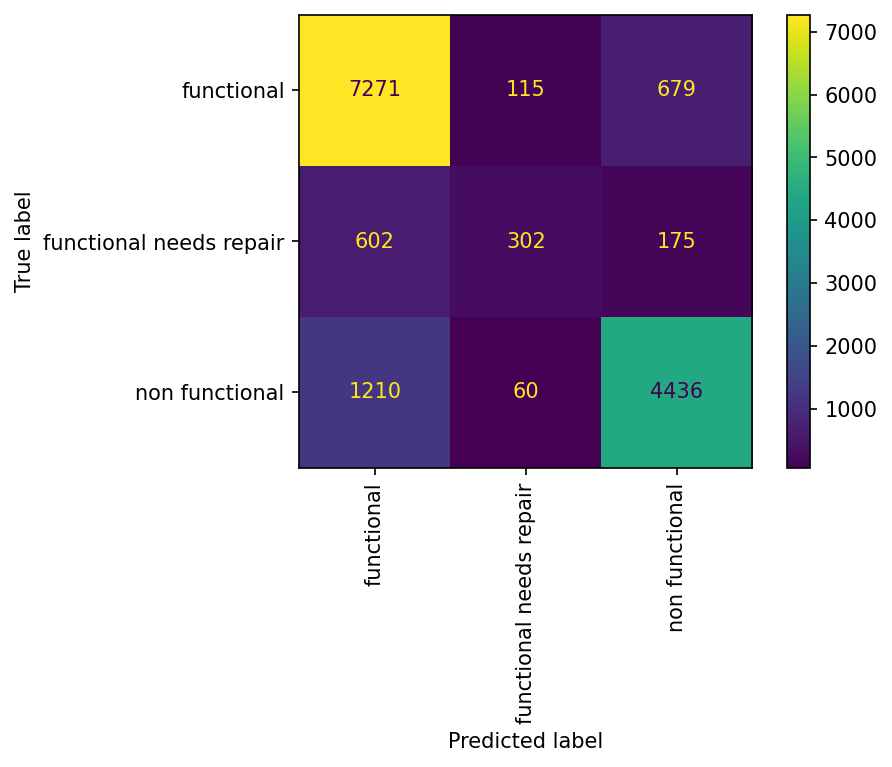

In [40]:
# Increase the dots per inch (dpi) to make confusion matrix larger:
plt.rcParams['figure.dpi'] = 150

# Plot my confusion matrix:
plot_confusion_matrix(rf_pipe, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [41]:
# Look at the classification report:
y_pred2 = rf_pipe.predict(X_val)
print(classification_report(y_val, y_pred2))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      8065
functional needs repair       0.63      0.28      0.39      1079
         non functional       0.84      0.78      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.76      0.65      0.68     14850
           weighted avg       0.80      0.81      0.80     14850



In [42]:
# Get the number of correct predictions:
correct_pred = 7271 + 302 + 4436

# Get the number of total predictions:
total_pred = 7271 + 115 + 679 + 602 + 302 + 175 + 1210 + 60 + 4436

# Get the accuracy percentage based on confusion matrix:
accuracy_pred = correct_pred / total_pred

# Compare my accuracy pred to the accuracy score:
acc_score = accuracy_score(y_val, y_pred2)

# Look at all the values:
print(f"My model's correct predictions are: {correct_pred} waterpumps out of {total_pred} waterpumps.\n")
print(f"My Model's accuracy percentage is: {accuracy_pred * 100:,.2f}% of correct predictions.\n")
print(f"My Model's accuracy score is: {acc_score *100:,.2f}% vs my percentage of correct predictions of {accuracy_pred * 100:,.2f}%.")

My model's correct predictions are: 12009 waterpumps out of 14850 waterpumps.

My Model's accuracy percentage is: 80.87% of correct predictions.

My Model's accuracy score is: 80.87% vs my percentage of correct predictions of 80.87%.


In [43]:
# Make targets binary:
y_train2 = y_train != 'functional'
y_val2 = y_val != 'functional'

# Look at the values to check my work:
y_train2.value_counts(normalize=True)

False    0.543075
True     0.456925
Name: status_group, dtype: float64

In [44]:
# Refit my model using the new target vector:
rf_pipe.fit(X_train, y_train2)
y_pred3 = rf_pipe.predict(X_val)

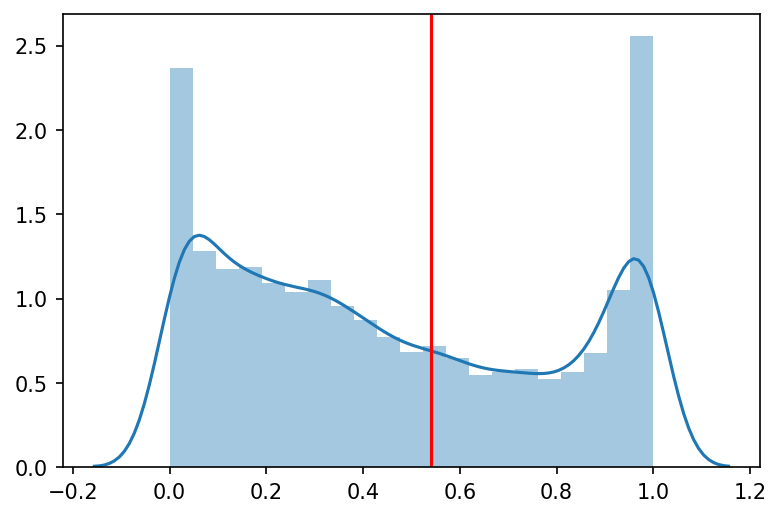

In [45]:
# Visualize the probility that a waterpump is functional with the threshold being the mean:
y_pred_prob = rf_pipe.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_prob)
plt.axvline(0.54, color='red');

In [46]:
# Create a function for my confusion matrix:
def my_con_mat(y_true, y_pred3):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred3), columns=columns, index=index)
  return sns.heatmap(table, annot=True, fmt='d', cmap='YlGnBu')

# Create a function for setting the threshold:
def set_threshold(y_true, y_pred_prob, threshold=0.54):
  y_pred3 = y_pred_prob > threshold
  ax = sns.distplot(y_pred_prob)
  ax.axvline(threshold, color='red')
  plt.show()
  print(classification_report(y_true, y_pred3))
  my_con_mat(y_true, y_pred3)

# Make it interactive:
interact(set_threshold, y_true=fixed(y_val2), y_pred_prob=fixed(y_pred_prob), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.54, description='threshold', max=1.0, step=0.02), Output()), _dom_cl…

### Continue Participating in Kaggle Challenge
- [x] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).  <---DONE !
- [x] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_  <--- DONE !


In [47]:
# Get submission cvs to upload to Kaggle Challenge:
submission=test[['id']].copy()
submission['status_group']=y_pred
submission.to_csv('Joanne_Middour_Submission17.csv',index=False)

In [48]:
submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


- [x] Commit your notebook to your fork of the GitHub repo.  <--- DONE !
- [x] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.  <--- DONE !

## Stretch Goals

### Reading

- [x] [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [x] [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [x] [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)




### Doing
- [ ] Share visualizations in our Slack channel!
- [x] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [x] More Categorical Encoding. (See module 2 assignment notebook)